Use all modules as dataset instead (w/weights to balance out different amt of students for each module)

In [3]:
import gdown

# Downloading the Kaggle Dataset.
file_ids = ["1m99RBSAG4zIPOJ2nfRupHj-jZDteTr6G", "1p-bKN89n-r-HnDGRmVF2tDpvHA5DUv0w", "1XDBeNesyWO9YKVxh5fGtzQM4V-YXL_ZJ","1hakH4A1exZu58b8AEakkJFNktCGjMoAH","1Tf03LIjkD3GsLHO_meTUocIhdZ-uZHbM","1eInNXFn5ibTRT6R5P5ntn5jw8G-sWoPA","1YZymTI35b22W8Z_X371xAIYUWz7SztLW"]  # Add all file IDs here
destinations=["assessments.csv","courses.csv","studentAssessment.csv","studentInfo.csv","studentRegistration.csv","studentVle.csv","vle.csv"]
for i, file_id in enumerate(file_ids, 0):
    destination = f"file_{i}.csv"
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, destinations[i], quiet=False)
    print(f"Downloaded: {destinations[i]}")

Downloading...
From: https://drive.google.com/uc?id=1m99RBSAG4zIPOJ2nfRupHj-jZDteTr6G
To: /Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/2)ML_Algo/assessments.csv
100%|██████████| 8.20k/8.20k [00:00<00:00, 12.4MB/s]


Downloaded: assessments.csv


Downloading...
From: https://drive.google.com/uc?id=1p-bKN89n-r-HnDGRmVF2tDpvHA5DUv0w
To: /Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/2)ML_Algo/courses.csv
100%|██████████| 526/526 [00:00<00:00, 588kB/s]


Downloaded: courses.csv


Downloading...
From: https://drive.google.com/uc?id=1XDBeNesyWO9YKVxh5fGtzQM4V-YXL_ZJ
To: /Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/2)ML_Algo/studentAssessment.csv
100%|██████████| 5.69M/5.69M [00:00<00:00, 20.0MB/s]


Downloaded: studentAssessment.csv


Downloading...
From: https://drive.google.com/uc?id=1hakH4A1exZu58b8AEakkJFNktCGjMoAH
To: /Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/2)ML_Algo/studentInfo.csv
100%|██████████| 3.46M/3.46M [00:00<00:00, 8.34MB/s]


Downloaded: studentInfo.csv


Downloading...
From: https://drive.google.com/uc?id=1Tf03LIjkD3GsLHO_meTUocIhdZ-uZHbM
To: /Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/2)ML_Algo/studentRegistration.csv
100%|██████████| 1.11M/1.11M [00:00<00:00, 14.5MB/s]


Downloaded: studentRegistration.csv


Downloading...
From (original): https://drive.google.com/uc?id=1eInNXFn5ibTRT6R5P5ntn5jw8G-sWoPA
From (redirected): https://drive.google.com/uc?id=1eInNXFn5ibTRT6R5P5ntn5jw8G-sWoPA&confirm=t&uuid=b7468ad8-6f95-426d-bf40-908f47c4988f
To: /Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/2)ML_Algo/studentVle.csv
100%|██████████| 454M/454M [00:12<00:00, 37.2MB/s] 


Downloaded: studentVle.csv


Downloading...
From: https://drive.google.com/uc?id=1YZymTI35b22W8Z_X371xAIYUWz7SztLW
To: /Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/2)ML_Algo/vle.csv
100%|██████████| 260k/260k [00:00<00:00, 5.98MB/s]

Downloaded: vle.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# ============================
# Data Loading and Merging
# ============================

# 1. Load your CSV files into DataFrames
df_assessments = pd.read_csv("assessments.csv")
df_courses = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle = pd.read_csv("studentVle.csv")
df_vle = pd.read_csv("vle.csv")

# Count how many unique assessments exist for each module + presentation
df_course_assess_count = (
    df_assessments
    .groupby(["code_module", "code_presentation"])["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "total_assessments"})
)

# Count how many assessments each student attempted
df_attempted_count = (
    df_studentAssessment
    .groupby("id_student")["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "num_assessments_attempted"})
)

# Compute average score for each student
df_avg_score = (
    df_studentAssessment
    .groupby("id_student")["score"]
    .mean()  # or .sum() if you prefer total score
    .reset_index()
    .rename(columns={"score": "score"})
)

df_vle_clicks = (
    df_studentVle
    .groupby("id_student")["sum_click"]
    .sum()
    .reset_index()
    .rename(columns={"sum_click": "total_vle_clicks"})
)

# 3.1 Merge total_assessments (on code_module + code_presentation)
df_merged = pd.merge(
    df_studentInfo,
    df_course_assess_count,
    on=["code_module", "code_presentation"],
    how="left"
)

# 3.2 Merge attempted_assessments & average_score (on id_student)
df_merged = pd.merge(
    df_merged,
    df_attempted_count,
    on="id_student",
    how="left"
)

df_merged = pd.merge(
    df_merged,
    df_avg_score,
    on="id_student",
    how="left"
)

# 3.3 Merge total_vle_clicks (on id_student)
df_merged = pd.merge(
    df_merged,
    df_vle_clicks,
    on="id_student",
    how="left"
)

# Replace NaN with 0 if needed
df_merged["num_assessments_attempted"] = df_merged["num_assessments_attempted"].fillna(0)
df_merged["total_assessments"] = df_merged["total_assessments"].fillna(0)
df_merged["score"] = df_merged["score"].fillna(0)  # if missing, assume 0 or handle differently
df_merged["total_vle_clicks"] = df_merged["total_vle_clicks"].fillna(0)

# Compute assessment_completion_ratio safely
def completion_ratio(row):
    if row["total_assessments"] == 0:
        return 0
    return row["num_assessments_attempted"] / row["total_assessments"]

df_merged["assessment_completion_ratio"] = df_merged.apply(completion_ratio, axis=1)

# Filter out withdrawn
df_merged = df_merged[
    (df_merged["final_result"] != "Withdrawn") 
].copy()

# Create binary target (Pass/Distinction=1, Fail=0)
df_merged["target"] = df_merged["final_result"].apply(
    lambda x: 1 if x in ["Pass", "Distinction"] else 0
)

# Rename columns for clarity
df_merged.rename(
    columns={
        "highest_education": "HLE",
        "age_band": "Age group",
        "studied_credits": "Credit Distribution",
        "gender": "Gender",
        "region": "Region"
    },
    inplace=True
)

# ---------------------------
# Final DataFrame including module
# ---------------------------
df_final = df_merged[
    [
        "id_student",
        "code_module",            # <-- include the module feature here
        "score",
        "Gender",
        "Region",
        "HLE",
        "Age group",
        "Credit Distribution",
        "assessment_completion_ratio",
        "total_vle_clicks",
        "target"
    ]
].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))


    id_student code_module  score Gender                Region  \
0        11391         AAA   82.0      M   East Anglian Region   
1        28400         AAA   66.4      F              Scotland   
3        31604         AAA   76.0      F     South East Region   
4        32885         AAA   54.4      F  West Midlands Region   
5        38053         AAA   68.0      M                 Wales   
6        45462         AAA   68.0      M              Scotland   
7        45642         AAA   72.4      F  North Western Region   
8        52130         AAA   71.4      F   East Anglian Region   
9        53025         AAA   78.0      M          North Region   
10       57506         AAA   74.0      M          South Region   

                            HLE Age group  Credit Distribution  \
0              HE Qualification      55<=                  240   
1              HE Qualification     35-55                   60   
3         A Level or Equivalent     35-55                   60   
4        

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# Define features including the module and separate target
features = [
    'score', 'Gender', 'Region', 'HLE', 'Age group',
    'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks',
    'code_module'  # include module
]

X = df_final[features]
y = df_final['target']

# One-hot encode categorical variables (including code_module)
X_encoded = pd.get_dummies(
    X, 
    columns=['Gender', 'Region', 'HLE', 'Age group', 'code_module'], 
    drop_first=True
)

# -----------------------------------
# Create Sample Weights by Module
# -----------------------------------
# Compute module counts and assign a weight = 1 / count for each sample
module_counts = df_final['code_module'].value_counts()
df_final['module_weight'] = df_final['code_module'].map(lambda m: 1.0 / module_counts[m])
sample_weights = df_final['module_weight']

# -----------------------------------
# Split the data into training and test sets
# -----------------------------------
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_encoded, y, sample_weights, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------------
# 1. Decision Tree Classifier with class_weight and sample weights
# -----------------------------------
clf_dt = DecisionTreeClassifier(
    max_depth=3,
    class_weight='balanced',  # addressing class imbalance as well
    random_state=42
)
clf_dt.fit(X_train, y_train, sample_weight=w_train)
y_pred_dt = clf_dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
balanced_accuracy_dt = balanced_accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree Balanced Accuracy:", balanced_accuracy_dt)
print("Decision Tree F1 Score:", f1_dt)
# print("Decision Tree Confusion Matrix:\n", cm_dt)
df_cm_dt = pd.DataFrame(
    cm_dt, 
    columns=["Predicted: Fail", "Predicted: Pass"], 
    index=["Actual: Fail", "Actual: Pass"]
)

print("Decision Tree Confusion Matrix:")
print(df_cm_dt.to_string())  # Printing as a formatted table

# -----------------------------------
# 2. Random Forest Classifier with class_weight and sample weights
# -----------------------------------
clf_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    bootstrap=True,
    oob_score=True,
    class_weight='balanced',
    random_state=42
)
clf_rf.fit(X_train, y_train, sample_weight=w_train)
y_pred_rf = clf_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
oob_score_rf = clf_rf.oob_score_

print("\nRandom Forest Accuracy:", accuracy_rf)
print("Random Forest Balanced Accuracy:", balanced_accuracy_rf)
print("Random Forest F1 Score:", f1_rf)
# print("Random Forest Confusion Matrix:\n", cm_rf)
df_cm_rf = pd.DataFrame(
    cm_rf, 
    columns=["Predicted: Fail", "Predicted: Pass"], 
    index=["Actual: Fail", "Actual: Pass"]
)

print("Random Forest Confusion Matrix:")
print(df_cm_rf.to_string())  # Printing as a formatted table
print("Random Forest OOB Score:", oob_score_rf)

# -----------------------------------
# 3. AdaBoost Classifier with base estimator having class_weight and sample weights
# -----------------------------------
base_estimator = DecisionTreeClassifier(
    max_depth=1,
    class_weight='balanced',  # base estimator with class_weight
    random_state=42
)
clf_ab = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    random_state=42
)
clf_ab.fit(X_train, y_train, sample_weight=w_train)
y_pred_ab = clf_ab.predict(X_test)

accuracy_ab = accuracy_score(y_test, y_pred_ab)
balanced_accuracy_ab = balanced_accuracy_score(y_test, y_pred_ab)
f1_ab = f1_score(y_test, y_pred_ab)
cm_ab = confusion_matrix(y_test, y_pred_ab)

print("\nAdaBoost Accuracy:", accuracy_ab)
print("AdaBoost Balanced Accuracy:", balanced_accuracy_ab)
print("AdaBoost F1 Score:", f1_ab)
# print("AdaBoost Confusion Matrix:\n", cm_ab)
df_cm_ab = pd.DataFrame(
    cm_ab, 
    columns=["Predicted: Fail", "Predicted: Pass"], 
    index=["Actual: Fail", "Actual: Pass"]
)

print("AdaBoost Confusion Matrix:")
print(df_cm_ab.to_string())  # Printing as a formatted table

# -----------------------------------
# 4. Logistic Regression with Class Weights and Sample Weights
# -----------------------------------
clf_lr = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced',  # Addressing class imbalance
    random_state=42
)
clf_lr.fit(X_train, y_train, sample_weight=w_train)
y_pred_lr = clf_lr.predict(X_test)

# -----------------------------------
# Model Evaluation for Logistic Regression
# -----------------------------------
accuracy_lr = accuracy_score(y_test, y_pred_lr)
balanced_accuracy_lr = balanced_accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("\nLogistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Balanced Accuracy:", balanced_accuracy_lr)
print("Logistic Regression F1 Score:", f1_lr)
# print("Logistic Regression Confusion Matrix:\n", cm_lr)
# -----------------------------------
# Print Confusion Matrix in a Table Format
# -----------------------------------
df_cm_lr = pd.DataFrame(
    cm_lr, 
    columns=["Predicted: Fail", "Predicted: Pass"], 
    index=["Actual: Fail", "Actual: Pass"]
)

print("Logistic Regression Confusion Matrix:")
print(df_cm_lr.to_string())  # Printing as a formatted table

Decision Tree Accuracy: 0.8862745098039215
Decision Tree Balanced Accuracy: 0.8442547404176867
Decision Tree F1 Score: 0.9202898550724637
Decision Tree Confusion Matrix:
              Predicted: Fail  Predicted: Pass
Actual: Fail             1289              474
Actual: Pass              164             3683

Random Forest Accuracy: 0.8759358288770054
Random Forest Balanced Accuracy: 0.8327218607482078
Random Forest F1 Score: 0.9129782445611403
Random Forest Confusion Matrix:
              Predicted: Fail  Predicted: Pass
Actual: Fail             1263              500
Actual: Pass              196             3651
Random Forest OOB Score: 0.8773994176026624

AdaBoost Accuracy: 0.8770053475935828
AdaBoost Balanced Accuracy: 0.8242835243291285
AdaBoost F1 Score: 0.9150664697193501
AdaBoost Confusion Matrix:
              Predicted: Fail  Predicted: Pass
Actual: Fail             1203              560
Actual: Pass              130             3717

Logistic Regression Accuracy: 0.79839572

### Decision Boundary Stuff

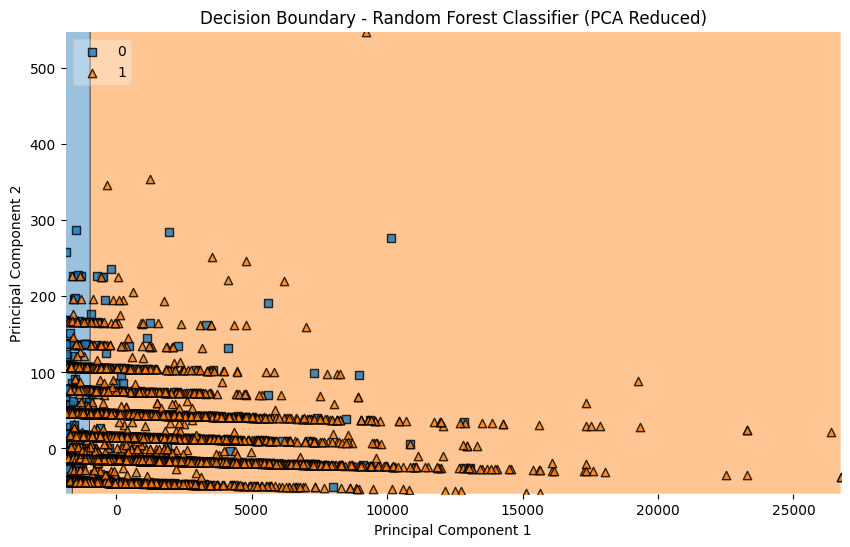

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

# Reduce dimensions to 2 using PCA (if necessary)
if X_train.shape[1] > 2:
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
else:
    X_train_pca = X_train.values
    X_test_pca = X_test.values

# Fit a RandomForest model on 2D transformed data
clf_rf_2d = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    bootstrap=True,
    oob_score=True,
    class_weight='balanced',
    random_state=42
)
clf_rf_2d.fit(X_train_pca, y_train)

# Plot decision boundary
plt.figure(figsize=(10, 6))
plot_decision_regions(X_train_pca, y_train.values, clf_rf_2d, legend=2)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Decision Boundary - Random Forest Classifier (PCA Reduced)")

plt.show()


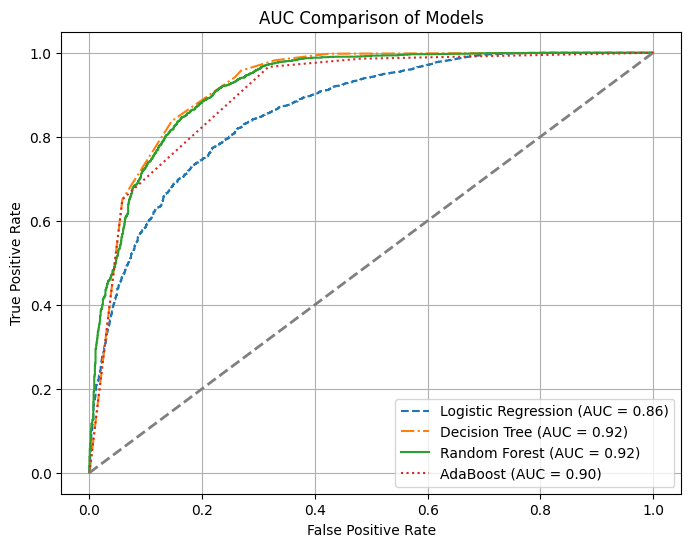

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get model probabilities for positive class (Pass = 1)
y_probs_lr = clf_lr.predict_proba(X_test)[:,1]
y_probs_dt = clf_dt.predict_proba(X_test)[:,1]
y_probs_rf = clf_rf.predict_proba(X_test)[:,1]
y_probs_ada = clf_ab.predict_proba(X_test)[:,1]

# Compute ROC curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probs_lr)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_probs_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_probs_ada)

# Compute AUC scores
auc_lr = auc(fpr_lr, tpr_lr)
auc_dt = auc(fpr_dt, tpr_dt)
auc_rf = auc(fpr_rf, tpr_rf)
auc_ada = auc(fpr_ada, tpr_ada)

# Plot ROC Curves
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})", linestyle='--')
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})", linestyle='-.')
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", linestyle='-')
plt.plot(fpr_ada, tpr_ada, label=f"AdaBoost (AUC = {auc_ada:.2f})", linestyle=':')

# Add reference line
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

# Formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Comparison of Models")
plt.legend(loc="lower right")
plt.grid()

# Show plot
plt.show()


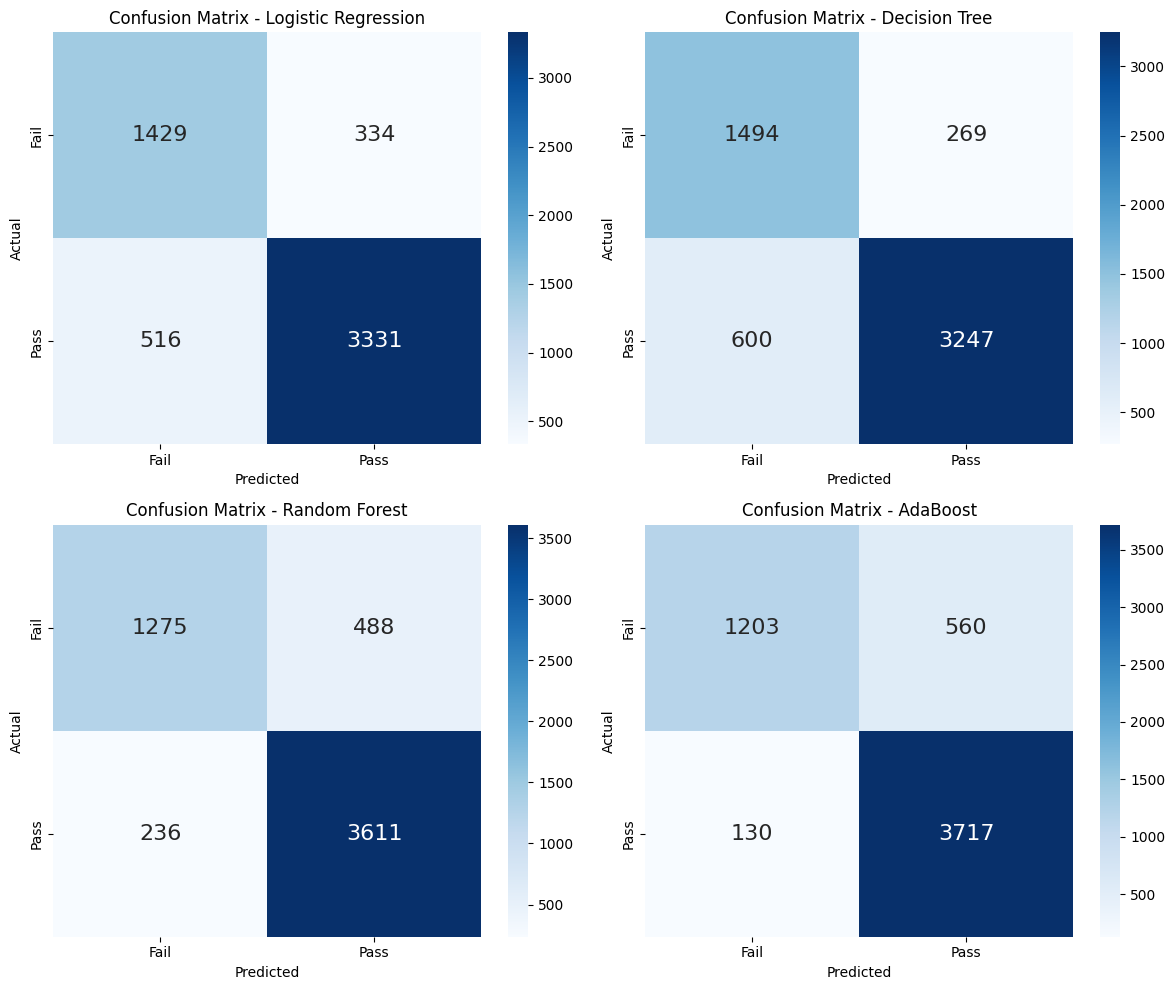

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

models = {
    "Logistic Regression": clf_lr,
    "Decision Tree": clf_dt,
    "Random Forest": clf_rf,
    "AdaBoost": clf_ab
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",annot_kws={"size": 16}, xticklabels=["Fail", "Pass"], yticklabels=["Fail", "Pass"], ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix - {model_name}")
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()


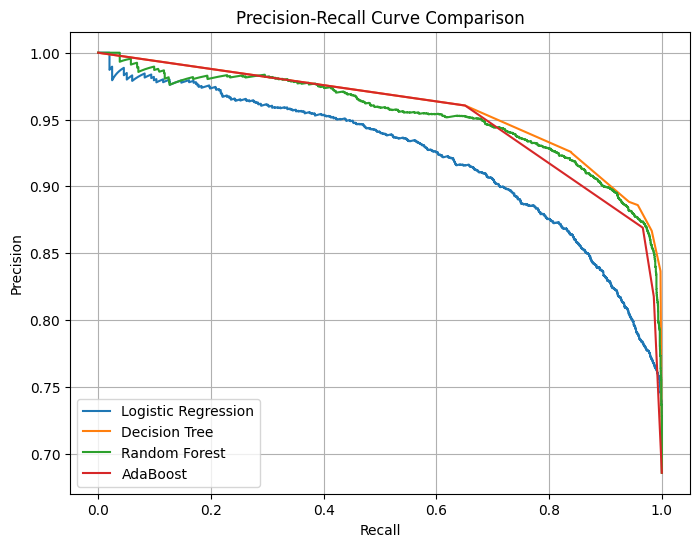

In [8]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall curves
precision_lr, recall_lr, _ = precision_recall_curve(y_test, clf_lr.predict_proba(X_test)[:,1])
precision_dt, recall_dt, _ = precision_recall_curve(y_test, clf_dt.predict_proba(X_test)[:,1])
precision_rf, recall_rf, _ = precision_recall_curve(y_test, clf_rf.predict_proba(X_test)[:,1])
precision_ada, recall_ada, _ = precision_recall_curve(y_test, clf_ab.predict_proba(X_test)[:,1])

# Plot
plt.figure(figsize=(8,6))
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.plot(recall_dt, precision_dt, label="Decision Tree")
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.plot(recall_ada, precision_ada, label="AdaBoost")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.grid()
plt.show()


/Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/var/folders/c7/vk9vgwps0nvb8mxt7b38nphc0000gn/T/ipykernel_55601/343645109.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_times, x="Training Time", y="Model", palette="coolwarm")


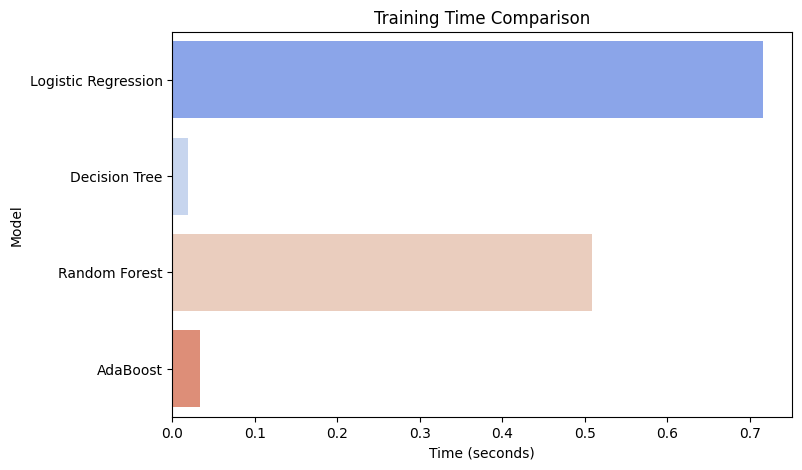

In [9]:
import time

models = {
    "Logistic Regression": clf_lr,
    "Decision Tree": clf_dt,
    "Random Forest": clf_rf,
    "AdaBoost": clf_ab
}

training_times = {}

for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    training_times[model_name] = time.time() - start_time

# Convert to DataFrame
df_times = pd.DataFrame(list(training_times.items()), columns=["Model", "Training Time"])

# Plot Bar Chart
plt.figure(figsize=(8,5))
sns.barplot(data=df_times, x="Training Time", y="Model", palette="coolwarm")
plt.title("Training Time Comparison")
plt.xlabel("Time (seconds)")
plt.ylabel("Model")
plt.show()


GridsearchCV finetuning

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Define features including the module and separate target
features = [
    'score', 'Gender', 'Region', 'HLE', 'Age group',
    'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks',
    'code_module'  # include module
]

X = df_final[features]
y = df_final['target']

# One-hot encode categorical variables (including code_module)
X_encoded = pd.get_dummies(
    X, 
    columns=['Gender', 'Region', 'HLE', 'Age group', 'code_module'], 
    drop_first=True
)

# -----------------------------------
# Create Sample Weights by Module
# -----------------------------------
# Compute module counts and assign a weight = 1 / count for each sample
module_counts = df_final['code_module'].value_counts()
df_final['module_weight'] = df_final['code_module'].map(lambda m: 1.0 / module_counts[m])
sample_weights = df_final['module_weight']

# -----------------------------------
# Split the data into training and test sets
# -----------------------------------
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_encoded, y, sample_weights, test_size=0.25, random_state=42, stratify=y
)

# ===========
# 1. Decision Tree with GridSearchCV
# ===========

param_grid_dt = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
grid_search_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid_dt,
    scoring='balanced_accuracy',  # or use 'accuracy' or other metric
    cv=5,
    n_jobs=-1,
    verbose=1
)
# Pass sample_weight via fit_params
grid_search_dt.fit(X_train, y_train, sample_weight=w_train)
best_dt = grid_search_dt.best_estimator_
print("Best Decision Tree Params:", grid_search_dt.best_params_)
print("Best Decision Tree CV Score:", grid_search_dt.best_score_)

# ===========
# 2. Random Forest with GridSearchCV
# ===========

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

rf = RandomForestClassifier(class_weight='balanced', bootstrap=True, random_state=42, oob_score=True)
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search_rf.fit(X_train, y_train, sample_weight=w_train)
best_rf = grid_search_rf.best_estimator_
print("Best Random Forest Params:", grid_search_rf.best_params_)
print("Best Random Forest CV Score:", grid_search_rf.best_score_)

# ===========
# 3. AdaBoost with GridSearchCV
# ===========

# For AdaBoost, we tune hyperparameters for the AdaBoost itself and its base estimator.
# Note: In GridSearchCV, parameters for the base estimator are prefixed with 'estimator__'
base_est = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=1)
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'estimator__max_depth': [1, 2, 3],
    'estimator__min_samples_split': [2, 5]
}

ada = AdaBoostClassifier(estimator=base_est, random_state=42)
grid_search_ada = GridSearchCV(
    estimator=ada,
    param_grid=param_grid_ada,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid_search_ada.fit(X_train, y_train, sample_weight=w_train)
best_ada = grid_search_ada.best_estimator_
print("Best AdaBoost Params:", grid_search_ada.best_params_)
print("Best AdaBoost CV Score:", grid_search_ada.best_score_)

# ===========
# Evaluation on Test Set (for all models)
# ===========

# Decision Tree Evaluation
y_pred_dt = best_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
balanced_accuracy_dt = balanced_accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("\nDecision Tree Test Set:")
print("Accuracy:", accuracy_dt)
print("Balanced Accuracy:", balanced_accuracy_dt)
print("F1 Score:", f1_dt)
print("Confusion Matrix:\n", cm_dt)

# Random Forest Evaluation
y_pred_rf = best_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
oob_score_rf = best_rf.oob_score_

print("\nRandom Forest Test Set:")
print("Accuracy:", accuracy_rf)
print("Balanced Accuracy:", balanced_accuracy_rf)
print("F1 Score:", f1_rf)
print("Confusion Matrix:\n", cm_rf)
print("OOB Score:", oob_score_rf)

# AdaBoost Evaluation
y_pred_ada = best_ada.predict(X_test)
accuracy_ada = accuracy_score(y_test, y_pred_ada)
balanced_accuracy_ada = balanced_accuracy_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)
cm_ada = confusion_matrix(y_test, y_pred_ada)

print("\nAdaBoost Test Set:")
print("Accuracy:", accuracy_ada)
print("Balanced Accuracy:", balanced_accuracy_ada)
print("F1 Score:", f1_ada)
print("Confusion Matrix:\n", cm_ada)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Decision Tree CV Score: 0.8612072419796716
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Random Forest Params: {'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest CV Score: 0.8690336673976627
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best AdaBoost Params: {'estimator__max_depth': 3, 'estimator__min_samples_split': 2, 'learning_rate': 0.01, 'n_estimators': 200}
Best AdaBoost CV Score: 0.8568870689894412

Decision Tree Test Set:
Accuracy: 0.8627450980392157
Balanced Accuracy: 0.8601302721909405
F1 Score: 0.8965331900026875
Confusion Matrix:
 [[1504  259]
 [ 511 3336]]

Random Forest Test Set:
Accuracy: 0.8805704099821747
Balanced Accuracy: 0.8674428778249613
F1 Score: 0.9120273109243697
Confusi

Optuna

In [9]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# --- Assume X_train, y_train, w_train are already defined ---
# Example: They come from your one-hot encoded data with sample weights

# ---------------------------
# 1. Decision Tree Tuning with Optuna
# ---------------------------
def objective_dt(trial):
    # Hyperparameter search space
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    
    clf = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        class_weight='balanced',
        random_state=42
    )
    
    # 5-fold stratified cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        w_tr = w_train.iloc[train_idx]
        X_val = X_train.iloc[valid_idx]
        y_val = y_train.iloc[valid_idx]
        clf.fit(X_tr, y_tr, sample_weight=w_tr)
        preds = clf.predict(X_val)
        scores.append(balanced_accuracy_score(y_val, preds))
    return np.mean(scores)

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt, n_trials=50)
print("Best Decision Tree Hyperparameters:", study_dt.best_params)
print("Best CV Balanced Accuracy (Decision Tree):", study_dt.best_value)

# ---------------------------
# 2. Random Forest Tuning with Optuna
# ---------------------------
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=True,
        class_weight='balanced',
        random_state=42,
        oob_score=True
    )
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        w_tr = w_train.iloc[train_idx]
        X_val = X_train.iloc[valid_idx]
        y_val = y_train.iloc[valid_idx]
        clf.fit(X_tr, y_tr, sample_weight=w_tr)
        preds = clf.predict(X_val)
        scores.append(balanced_accuracy_score(y_val, preds))
    return np.mean(scores)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)
print("Best Random Forest Hyperparameters:", study_rf.best_params)
print("Best CV Balanced Accuracy (Random Forest):", study_rf.best_value)

# ---------------------------
# 3. AdaBoost Tuning with Optuna
# ---------------------------
def objective_ada(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    # Tuning the base estimator's parameters
    base_max_depth = trial.suggest_int('estimator__max_depth', 1, 5)
    base_min_samples_split = trial.suggest_int('estimator__min_samples_split', 2, 10)
    
    base_est = DecisionTreeClassifier(
        max_depth=base_max_depth,
        min_samples_split=base_min_samples_split,
        class_weight='balanced',
        random_state=42
    )
    
    clf = AdaBoostClassifier(
        estimator=base_est,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr = X_train.iloc[train_idx]
        y_tr = y_train.iloc[train_idx]
        w_tr = w_train.iloc[train_idx]
        X_val = X_train.iloc[valid_idx]
        y_val = y_train.iloc[valid_idx]
        clf.fit(X_tr, y_tr, sample_weight=w_tr)
        preds = clf.predict(X_val)
        scores.append(balanced_accuracy_score(y_val, preds))
    return np.mean(scores)

study_ada = optuna.create_study(direction='maximize')
study_ada.optimize(objective_ada, n_trials=50)
print("Best AdaBoost Hyperparameters:", study_ada.best_params)
print("Best CV Balanced Accuracy (AdaBoost):", study_ada.best_value)


c:\Users\admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-01 21:38:31,801] A new study created in memory with name: no-name-1cee67ed-2fb6-4827-906c-d21eccf5b066
[I 2025-03-01 21:38:32,043] Trial 0 finished with value: 0.8304361075729794 and parameters: {'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 0 with value: 0.8304361075729794.
[I 2025-03-01 21:38:32,338] Trial 1 finished with value: 0.8278715831252844 and parameters: {'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 1, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8304361075729794.
[I 2025-03-01 21:38:32,536] Trial 2 finished with value: 0.845334756289227 and parameters: {'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf

Best Decision Tree Hyperparameters: {'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5, 'criterion': 'gini'}
Best CV Balanced Accuracy (Decision Tree): 0.8608391293798603


[I 2025-03-01 21:38:43,514] Trial 0 finished with value: 0.8652592271966425 and parameters: {'n_estimators': 124, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.8652592271966425.
[I 2025-03-01 21:38:50,071] Trial 1 finished with value: 0.867496179802734 and parameters: {'n_estimators': 211, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.867496179802734.
[I 2025-03-01 21:39:08,932] Trial 2 finished with value: 0.8674555278362467 and parameters: {'n_estimators': 197, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None}. Best is trial 1 with value: 0.867496179802734.
[I 2025-03-01 21:39:26,290] Trial 3 finished with value: 0.863903032249642 and parameters: {'n_estimators': 138, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 1 with value: 0.867496179802734.
[I 202

Best Random Forest Hyperparameters: {'n_estimators': 190, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': None}
Best CV Balanced Accuracy (Random Forest): 0.8680734158613381


[I 2025-03-01 21:48:50,867] Trial 0 finished with value: 0.8149035212510723 and parameters: {'n_estimators': 126, 'learning_rate': 0.021946989455914327, 'estimator__max_depth': 1, 'estimator__min_samples_split': 8}. Best is trial 0 with value: 0.8149035212510723.
C:\Users\admin\AppData\Local\Temp\ipykernel_10568\1341510049.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
[I 2025-03-01 21:48:51,350] Trial 1 finished with value: 0.8529667748834291 and parameters: {'n_estimators': 145, 'learning_rate': 0.41931181602958334, 'estimator__max_depth': 3, 'estimator__min_samples_split': 9}. Best is trial 1 with value: 0.8529667748834291.
C:\Users\admin\AppData\Local\Temp\ipykernel_10568\1341510049.py:95: FutureWarning: suggest_loguniform has been deprecated in v3.0

Best AdaBoost Hyperparameters: {'n_estimators': 114, 'learning_rate': 0.07629317213683631, 'estimator__max_depth': 5, 'estimator__min_samples_split': 4}
Best CV Balanced Accuracy (AdaBoost): 0.866368643405402


Optuna provided hyperparams

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Define features including the module and separate target
features = [
    'score', 'Gender', 'Region', 'HLE', 'Age group',
    'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks',
    'code_module'  # include module
]

X = df_final[features]
y = df_final['target']

# One-hot encode categorical variables (including code_module)
X_encoded = pd.get_dummies(
    X, 
    columns=['Gender', 'Region', 'HLE', 'Age group', 'code_module'], 
    drop_first=True
)

# -----------------------------------
# Create Sample Weights by Module
# -----------------------------------
module_counts = df_final['code_module'].value_counts()
df_final['module_weight'] = df_final['code_module'].map(lambda m: 1.0 / module_counts[m])
sample_weights = df_final['module_weight']

# -----------------------------------
# Split the data into training and test sets
# -----------------------------------
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_encoded, y, sample_weights, test_size=0.25, random_state=42, stratify=y
)

# ============
# 1. Decision Tree using Optuna-optimized Hyperparameters
# ============
# Optimized Hyperparameters:
#   max_depth = 6, min_samples_split = 9, min_samples_leaf = 5, criterion = 'gini'
best_dt = DecisionTreeClassifier(
    max_depth=6,
    min_samples_split=9,
    min_samples_leaf=5,
    criterion='gini',
    class_weight='balanced',
    random_state=42
)
best_dt.fit(X_train, y_train, sample_weight=w_train)
y_pred_dt = best_dt.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
balanced_accuracy_dt = balanced_accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("Decision Tree Test Set:")
print("Accuracy:", accuracy_dt)
print("Balanced Accuracy:", balanced_accuracy_dt)
print("F1 Score:", f1_dt)
print("Confusion Matrix:\n", cm_dt)

# ============
# 2. Random Forest using Optuna-optimized Hyperparameters
# ============
# Optimized Hyperparameters:
#   n_estimators = 190, max_depth = 7, min_samples_split = 10, min_samples_leaf = 5, max_features = None
best_rf = RandomForestClassifier(
    n_estimators=190,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features=None,
    bootstrap=True,
    class_weight='balanced',
    random_state=42,
    oob_score=True
)
best_rf.fit(X_train, y_train, sample_weight=w_train)
y_pred_rf = best_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
balanced_accuracy_rf = balanced_accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)
oob_score_rf = best_rf.oob_score_

print("\nRandom Forest Test Set:")
print("Accuracy:", accuracy_rf)
print("Balanced Accuracy:", balanced_accuracy_rf)
print("F1 Score:", f1_rf)
print("Confusion Matrix:\n", cm_rf)
print("OOB Score:", oob_score_rf)

# ============
# 3. AdaBoost using Optuna-optimized Hyperparameters
# ============
# Optimized Hyperparameters:
#   n_estimators = 114, learning_rate = 0.07629317213683631,
#   Base estimator: max_depth = 5, min_samples_split = 4
base_est = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=4,
    class_weight='balanced',
    random_state=42
)
best_ada = AdaBoostClassifier(
    estimator=base_est,
    n_estimators=114,
    learning_rate=0.07629317213683631,
    random_state=42
)
best_ada.fit(X_train, y_train, sample_weight=w_train)
y_pred_ada = best_ada.predict(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_ada)
balanced_accuracy_ada = balanced_accuracy_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)
cm_ada = confusion_matrix(y_test, y_pred_ada)

print("\nAdaBoost Test Set:")
print("Accuracy:", accuracy_ada)
print("Balanced Accuracy:", balanced_accuracy_ada)
print("F1 Score:", f1_ada)
print("Confusion Matrix:\n", cm_ada)


Decision Tree Test Set:
Accuracy: 0.8696969696969697
Balanced Accuracy: 0.863662796226804
F1 Score: 0.9025463271563792
Confusion Matrix:
 [[1494  269]
 [ 462 3385]]

Random Forest Test Set:
Accuracy: 0.8828877005347594
Balanced Accuracy: 0.8682106896210571
F1 Score: 0.9140164899882215
Confusion Matrix:
 [[1461  302]
 [ 355 3492]]
OOB Score: 0.8826291079812206

AdaBoost Test Set:
Accuracy: 0.8827094474153298
Balanced Accuracy: 0.8647007244339313
F1 Score: 0.9143675169182718
Confusion Matrix:
 [[1439  324]
 [ 334 3513]]
